In [1]:
# Define colors
Pitt.Blue<- "#003594"
Pitt.Gold<-"#FFB81C"
Pitt.DGray <- "#75787B"
Pitt.Gray <- "#97999B"
Pitt.LGray <- "#C8C9C7"
# ggplot preferences
library("ggplot2")
library("repr")
options(repr.plot.width=10, repr.plot.height=10/1.68)
Pitt.Theme<-theme( panel.background = element_rect(fill = "white", size = 0.5, linetype = "solid"),
  panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour =Pitt.Gray), 
  panel.grid.minor = element_line(size = 0.25, linetype = 'solid', colour = "white")
  )
base<- ggplot() +aes()+ Pitt.Theme

# Censoring, and Selection
---
We now focus on using maximum likelihood techniques to understanding some additional violations of the standard model that can cause bias.
* **Censoring**: whereby data above or below a certain value is measured only at the limit
* **Selection**: where the participants in our dataset are non-randomly selected, and so may be unrepresentative

## Censoring
---

Suppose that we are modelling the effect of variable $x$ on outcome $y$, where we'll use the classical linear model:
$$y_i=\beta_0+\beta_1 x_i+\epsilon_i$$
where $\epsilon_i\sim \mathcal{N}(0,\sigma^2)$.

So this would be the standard regression:

In [2]:
beta0 <- 5000
beta1 <- 2
x <- 100*rchisq(10000,df=2)
epsilon <- rnorm(10000,mean=0,sd=400)
y <- beta0+ beta1*x + epsilon
data <- data.frame(y=y,x=x)
lm(y~x,data=data)


Call:
lm(formula = y ~ x, data = data)

Coefficients:
(Intercept)            x  
   5004.607        1.972  


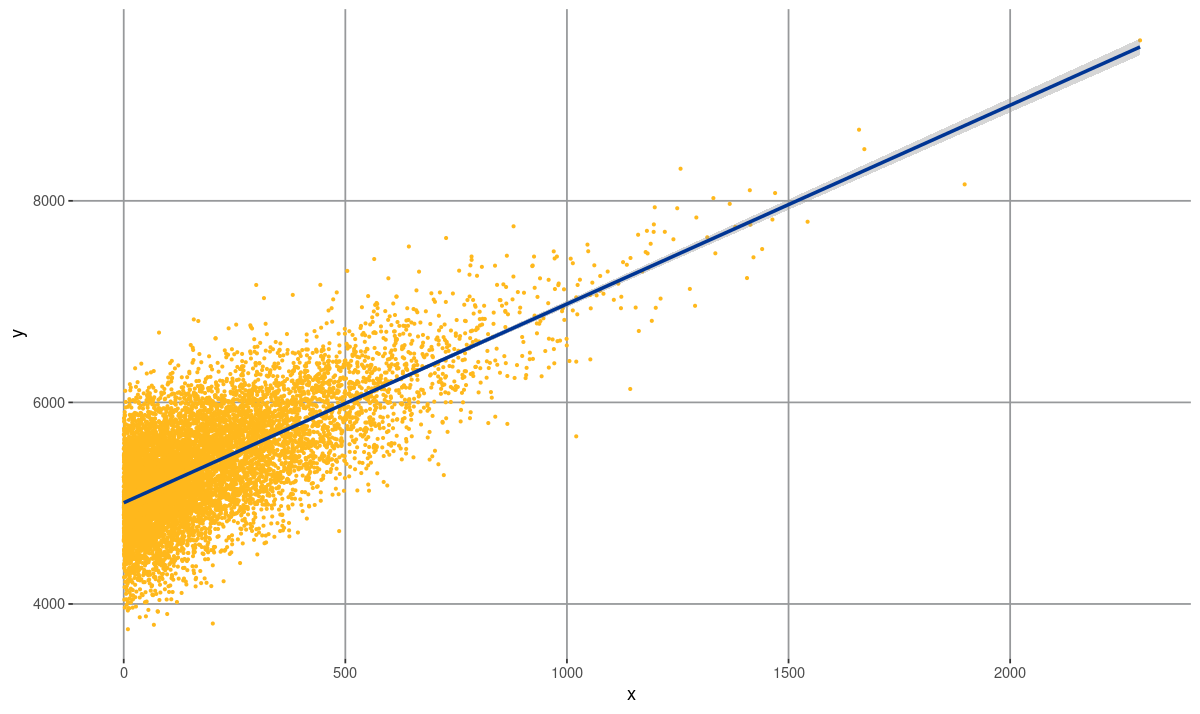

In [3]:
ggplot(data=data,aes(x=x,y=y))+
geom_point(size=0.5, color=Pitt.Gold)+
geom_smooth(method='lm',color=Pitt.Blue,formula='y~x')+Pitt.Theme
summary()

So here we do pretty well at estimating the effect of the variable $x$ on $y$.

However, suppose that due to data collection limits, we could only measure $y$ up to $\overline{y}=6000$, and for values above this they are *top-coded* at this limit.

In [4]:
y.upper <- 6000
data['y.censored'] <- ifelse(y>y.upper,y.upper,y)
lm(y.censored~x,data=data)


Call:
lm(formula = y.censored ~ x, data = data)

Coefficients:
(Intercept)            x  
   5083.027        1.315  


Now we've substantially underestimated the relationship between y and x, where we can see why when we consider the effect of the truncation:

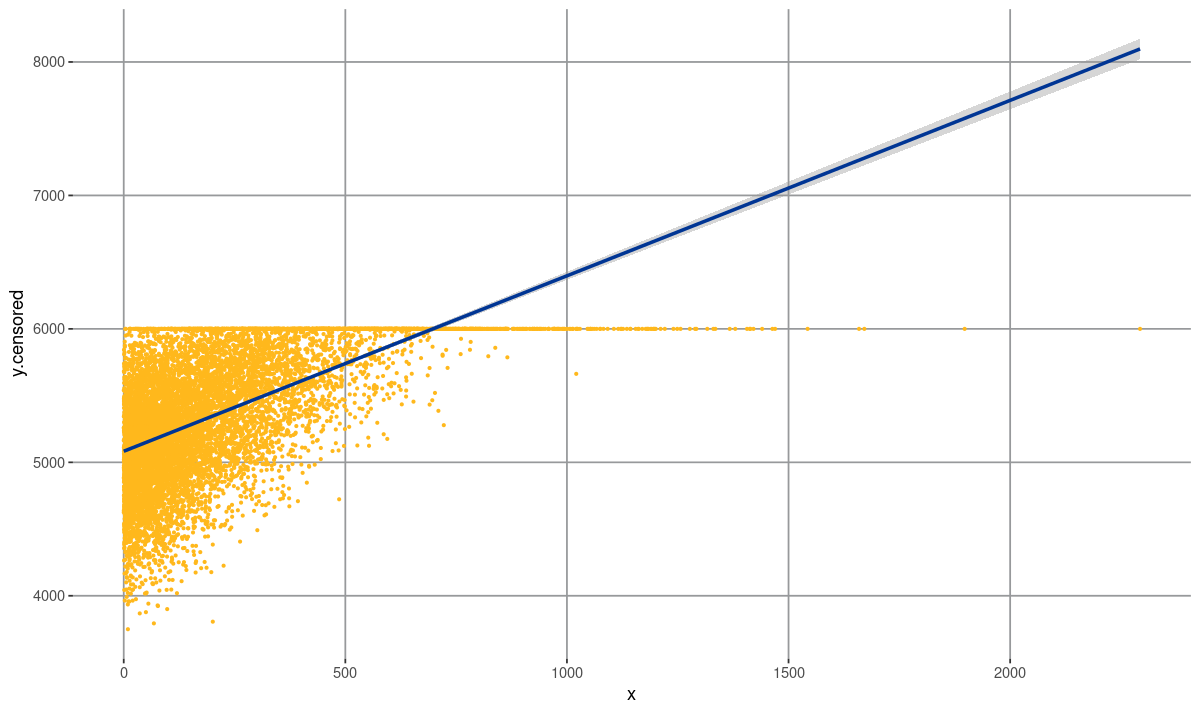

In [5]:
ggplot(data=data,aes(x=x,y=y.censored))+geom_point(size=0.5, color=Pitt.Gold)+geom_smooth(method='lm',color=Pitt.Blue,formula='y~x')+Pitt.Theme

The violation of the assumption here is that if the true relationship is:
$$ y=\beta_0+\beta_1 x+\epsilon$$
and we use the censored variable $y_C$ then we effectively have the relationship:
$$y_C=\begin{cases}
 \beta_0+\beta_1\cdot x_U+\epsilon & \text{if }\epsilon<\overline{y}-\beta_0-\beta_1 x, \\
 \overline{y} & \text{otherwise.}\end{cases} $$

If we wanted to estimate $\beta_1$ without bias, we would require that the expected error conditional on all values of $x$ is zero, but that can't be true here as the expected error on the top-coded variable is positive!


One way to proceed here would be to remove all of the top-coded observations:

In [6]:
lm(y.censored~x,data=data,subset=y.censored<6000)


Call:
lm(formula = y.censored ~ x, data = data, subset = y.censored < 
    6000)

Coefficients:
(Intercept)            x  
   5028.291        1.419  


But here we're still making a mistake, as the *expected* error  is now negative (increasingly so as $x$ gets larger) as we're truncating the sample to remove data points with large errors!

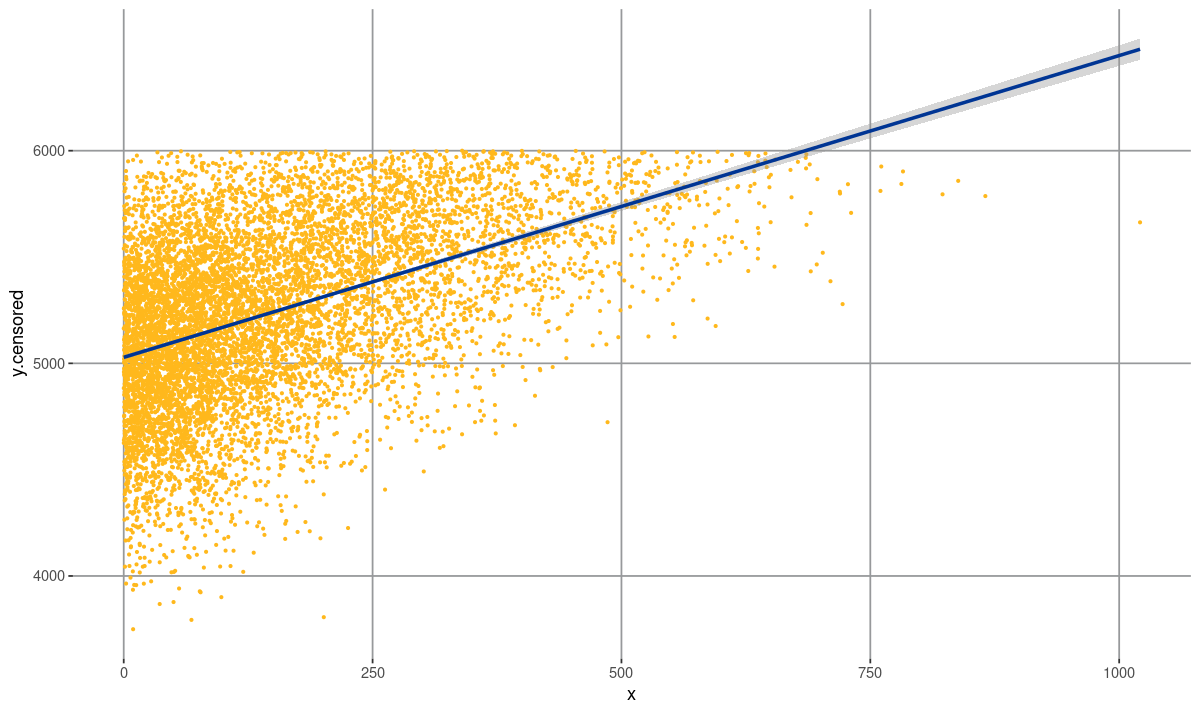

In [7]:
ggplot(data=subset(data,y.censored<6000),aes(x=x,y=y.censored))+geom_point(size=0.5, color=Pitt.Gold)+
geom_smooth(method='lm',color=Pitt.Blue,formula='y~x')+Pitt.Theme

The other option we have is to model the censoring. The starting point for much of this is what's called a Tobit regression. We will make the classical linear model assumption that the errors are normally distributed. However, we will now recognize the fact that data points at the upper limit are top coded.

The density on points which are uncensored are therefore given by the standard normal PDF:
$$\phi\left(\frac{y_i-\beta_0-\beta_1 x_i}{\sigma}\right)$$
This is the exactly the same as the max-likelihood version of the classical linear model.

The difference is that values at the upper limit $\overline{y}$ we recognize that all values of $\epsilon$ larger than a cutoff could have caused this. The likelihood for these data points is therefore given by the upper tail of the normal via:
$$\left(1-\Phi\left( \frac{\overline{y}-\beta_0-\beta_1 x_i}{\sigma} \right)\right) $$

Similarly, if we had bottom-coded variables, so left-censored at some point $\underline{y}$, then we would model the left tail of normal via:
$$ \Phi\left( \frac{\underline{y}-\beta_0-\beta_1 x_i}{\sigma} \right) $$

Given left and right censoring at $\underline{y}$ and $\overline{y}$, respectively,  the log-likelihood for the entire is data given by:
$$\begin{eqnarray}\log \mathcal{L}(\beta_0,\beta_1,\sigma;y,x)=
\sum_{\underline{y}<y_i<\overline{y}}\log\phi\left(\frac{y_i-\beta_0-\beta_1 x_i}{\sigma}\right)+\\
\sum_{\underline{y}\geq y_i}\log \Phi\left(\frac{y_i-\beta_0-\beta_1 x_i}{\sigma}\right)+\\
\sum_{y_i \geq  \overline{y} }\log\left( 1-\Phi\left(\frac{y_i-\beta_0-\beta_1 x_i}{\sigma}\right)\right),\end{eqnarray}
$$
and we could find the max-likelihood estimates $\hat{\beta}_0$ and $\hat{\beta}_1$ using the previous methods (and the standard deviation $\hat{\sigma}$ and standard errors).

This is all formulated using a number of different methods in R loaded in a few different packages, where we'll use the censReg package here telling it that the allowed interval for the dependent variable is $(-\infty, 6000)$ with the `left` and `right` parameters

In [8]:
#install.packages('censReg')
library(censReg)
Tobit.Est <- censReg(y.censored~x,data=data, left=-Inf,right=6000)
summary(Tobit.Est)

Loading required package: maxLik

Loading required package: miscTools


Please cite the 'maxLik' package as:
Henningsen, Arne and Toomet, Ott (2011). maxLik: A package for maximum likelihood estimation in R. Computational Statistics 26(3), 443-458. DOI 10.1007/s00180-010-0217-1.

If you have questions, suggestions, or comments regarding the 'maxLik' package, please use a forum or 'tracker' at maxLik's R-Forge site:
https://r-forge.r-project.org/projects/maxlik/


Please cite the 'censReg' package as:
Henningsen, Arne (2017). censReg: Censored Regression (Tobit) Models. R package version 0.5. http://CRAN.R-Project.org/package=censReg.

If you have questions, suggestions, or comments regarding the 'censReg' package, please use a forum or 'tracker' at the R-Forge site of the 'sampleSelection' project:
https://r-forge.r-project.org/projects/sampleselection/




Call:
censReg(formula = y.censored ~ x, left = -Inf, right = 6000, 
    data = data)

Observations:
         Total  Left-censored     Uncensored Right-censored 
         10000              0           8667           1333 

Coefficients:
             Estimate Std. error t value Pr(> t)    
(Intercept) 5.003e+03  6.167e+00  811.25  <2e-16 ***
x           1.989e+00  2.686e-02   74.02  <2e-16 ***
logSigma    5.996e+00  7.721e-03  776.49  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Newton-Raphson maximisation, 7 iterations
Return code 1: gradient close to zero (gradtol)
Log-likelihood: -65232.42 on 3 Df


Note that the error standard deviation is given by it's log, where we should be expecting $\sigma=400$

In [9]:
log(400)

[1] 5.991465

If we had censoring on both sides we could the specify both the lower and upper censoring points as:

In [10]:
y.lower <- 4500
data['y.dbl.censored'] <- ifelse(data$y.censored<y.lower,y.lower,data$y.censored)
Tobit.Est.2 <- censReg(y.dbl.censored~x,data=data, left=y.lower,right=y.upper)
summary(Tobit.Est.2)


Call:
censReg(formula = y.dbl.censored ~ x, left = y.lower, right = y.upper, 
    data = data)

Observations:
         Total  Left-censored     Uncensored Right-censored 
         10000            363           8304           1333 

Coefficients:
             Estimate Std. error t value Pr(> t)    
(Intercept) 5.003e+03  6.195e+00  807.66  <2e-16 ***
x           1.987e+00  2.694e-02   73.75  <2e-16 ***
logSigma    5.994e+00  7.992e-03  749.98  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Newton-Raphson maximisation, 6 iterations
Return code 8: successive function values within relative tolerance limit (reltol)
Log-likelihood: -62989.5 on 3 Df


Tobit models are therefore a useful technique for removing the effects of boundary observations. For example, if you were trying to understand the effects of characteristics on wages, you would encounter many individuals at minimum wages (dictated at either the state or federal level), a Tobit might be your first step to understanding how this censoring might be affecting your inference. Note though, that the normal distribution is doing a log of the heavy lifting here! 

There are other methods that weaken the strong distributional assumptions in the Tobit, but they're beyond the scope of this course! (keywords: *non-parametric* or *semi-parametric* censored regression)

The other type of censored data you might encounter is interval censored data. That is, instead of observing the true value $y$ you instead see that it lies in the interval $[\underline{y}_i,\overline{y}_i]$. For example, from a survey, a respondent might select a household income category of:
$$ \$50,000 \text{ to } \$60,000$$

Here I'll just do it so that each data point is in an interval of width \$250, except for the lower and upper intervals

In [ ]:
data['y.int.lower'] <- ifelse(data$y>4500, floor(data$y/250)*250 , -Inf )
data['y.int.upper'] <- ifelse(data$y<6000, ceiling(data$y/250)*250,Inf)

In [ ]:
head(data[,c('y.int.lower','y.int.upper','x')],6)

There is a package that I does interval regression, but it is unfortunately not available for my version of R!

So I just defined the negative log-likelihood of the interval data using the Tobit-like Normal assumption on the error.

In [ ]:
nll.intReg <-  function(beta){
   -sum(log(
       pnorm((data$y.int.upper- beta[1]-beta[2]*data$x)/beta[3])- 
       pnorm((data$y.int.lower- beta[1]-beta[2]*data$x)/beta[3])))
    }

In [ ]:
# Maximum likelihood!
optim(c(5500,3,300), nll.intReg)

## Selection models
While in some cases we observe values which are either top or bottom-coded, sometimes we just don't have data on some observations at all. The canonical example in Economics is on wages, and labor force participation.

When we look at the wages of a number of workers, implicitly we are examining a selection for the workers who were willing to work at the offered wages.

So, there is a hidden binary variable:
* work at the offered wages
* don't work at the offered wages

Conditional on accepting the offer, we then observe the wages, and characteristics.

So, if we're trying to investigate what leads to higher/lower wages, we would want to understand both how characteristics are mapped into wage offers **and** whether those offers are accepted or declined.

The Heckman selection model uses a pair of limited dependent variables to understand the effects. 
* A wage-offer equation: $$ w_i^\star= x_i^T \beta +\epsilon^{\text{Ofr}}_i$$
* A selection equation: $$ u_i^\star= z_i^T\delta  +\epsilon^{\text{Sel}}_i$$ 

where $x_i$ and $z_i$ are possibly overlapping sets of predictors for person $i$ 

As the analyst, we do not perfectly observe the latent variables $u^\star_i$ (the relative happiness for working) and $w_i^\star$ (the wage *offer*), we instead see the two limited variables:
*  The *currently employed* variable: $$ u_i = \begin{cases}1 & \text{if }u^\star_i \geq 0 \\ 0 & \text{if }u^\star_i < 0\end{cases}$$
*  The *accepted-wage* variable:
$$ w_i = \begin{cases}w^\star_i & \text{if }u_i =1 \\ 0 & \text{otherwise}\end{cases}$$


If for example we made the assumption that:
$$\left(\begin{array}{c}\epsilon^{\text{Ofr}}_i\\ \epsilon^{\text{Sel}}_i\end{array}\right) \sim \mathcal{N}\left(0,\Sigma\right)$$
then the employed variable in the selection equation would be very similar to a Probit estimate, while the wage variable would be similar to a Tobit.

In addition, the variance-covariance matrix $\Sigma$ allows there to be correlation across the two errors, so something unobservabed by the analyst that causes somoene to have low wage offers might also cause them to be more/less picky with those offers.  

Because scale is not identified for the binary decision, the variance covariance matrix we are looking for is given by:
$$\Sigma=\left[\begin{array}{cc} 1 & \rho\\ \rho & \sigma^2 \end{array}\right] $$
where $\sigma^2$ tells us the variability of the wages and $\rho$ gives us the correlation between the errors.

We can estimate this selection model using maximum likelihood via the `sampleSelection` package, where this particular model is also called a Tobit Type 2 model.

In [11]:
library(sampleSelection)

Let's look at the canonical version of this, which is included in the packages data and [vignettes](https://cran.r-project.org/web/packages/sampleSelection/vignettes/selection.pdf). This is data from 1975 on married women's labor-force participation decisions (variable `lfp`) and wages that was examined in [Mroz (1987)](https://doi.org/10.2307/1911029)

In [12]:
data( "Mroz87" )
head(Mroz87)

lfp hours kids5 kids618 age educ wage   repwage hushrs husage <U+22EF>   faminc
1 1   1610  1     0       32  12   3.3540 2.65    2708   34     <U+22EF> 16310 
2 1   1656  0     2       30  12   1.3889 2.65    2310   30     <U+22EF> 21800 
3 1   1980  1     3       35  12   4.5455 4.04    3072   40     <U+22EF> 21040 
4 1    456  0     3       34  12   1.0965 3.25    1920   53     <U+22EF>  7300 
5 1   1568  1     2       31  14   4.5918 3.60    2000   32     <U+22EF> 27300 
6 1   2032  0     0       54  12   4.7421 4.70    1040   57     <U+22EF> 19495 
  mtr    motheduc fatheduc unem city exper nwifeinc  wifecoll huscoll
1 0.7215 12        7        5.0 0    14    10.910060 FALSE    FALSE  
2 0.6615  7        7       11.0 1     5    19.499981 FALSE    FALSE  
3 0.6915 12        7        5.0 0    15    12.039910 FALSE    FALSE  
4 0.7815  7        7        5.0 0     6     6.799996 FALSE    FALSE  
5 0.6215 12       14        9.5 1     7    20.100058  TRUE    FALSE  
6 0.6915 14        7        7.5 1    33     9.859054 FALSE    FALSE

In [13]:
summary(Mroz87[,c('lfp','age','faminc','educ','exper','city')])

      lfp              age            faminc           educ      
 Min.   :0.0000   Min.   :30.00   Min.   : 1500   Min.   : 5.00  
 1st Qu.:0.0000   1st Qu.:36.00   1st Qu.:15428   1st Qu.:12.00  
 Median :1.0000   Median :43.00   Median :20880   Median :12.00  
 Mean   :0.5684   Mean   :42.54   Mean   :23081   Mean   :12.29  
 3rd Qu.:1.0000   3rd Qu.:49.00   3rd Qu.:28200   3rd Qu.:13.00  
 Max.   :1.0000   Max.   :60.00   Max.   :96000   Max.   :17.00  
     exper            city       
 Min.   : 0.00   Min.   :0.0000  
 1st Qu.: 4.00   1st Qu.:0.0000  
 Median : 9.00   Median :1.0000  
 Mean   :10.63   Mean   :0.6428  
 3rd Qu.:15.00   3rd Qu.:1.0000  
 Max.   :45.00   Max.   :1.0000  

Making a dummy variable for having children which will serve as one of the variables that is modeled to affect the particpation decision but not the wage offer.

In [14]:
Mroz87$has.children <- ( Mroz87$kids5 + Mroz87$kids618 > 0 )

We the specify the two equations as:
* **Selection** $\Pr\left\{\text{In Labor force}\right\}=\delta_0 + \delta_1\cdot\text{age} +\delta_2\cdot \text{age}^2 +\delta_3\cdot \text{fam.income}+\delta_4\cdot \text{has.children}+\delta_5\cdot \text{educ}$
* **Outcome** $ \mathbb{E}\text{Wage}|x = \beta_0+\beta_1\cdot\text{exper} +\beta_2\cdot \text{exper}^2+\beta_3\cdot\text{educ}+\beta_4\cdot\text{city}$ 

This is then estimated using the `selection()` command:

In [15]:
lfp.est <- selection( selection=lfp ~ age + I( age^2 ) + faminc + has.children + educ, 
         outcome=wage ~ exper + I( exper^2 ) + educ + city, 
          data = Mroz87, iterlim = 500 )
summary(lfp.est)

--------------------------------------------
Tobit 2 model (sample selection model)
Maximum Likelihood estimation
Newton-Raphson maximisation, 5 iterations
Return code 8: successive function values within relative tolerance limit (reltol)
Log-Likelihood: -1581.258 
753 observations (325 censored and 428 observed)
13 free parameters (df = 740)
Probit selection equation:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -4.120e+00  1.401e+00  -2.942 0.003368 ** 
age               1.840e-01  6.587e-02   2.794 0.005345 ** 
I(age^2)         -2.409e-03  7.723e-04  -3.119 0.001886 ** 
faminc            5.680e-06  4.416e-06   1.286 0.198782    
has.childrenTRUE -4.506e-01  1.302e-01  -3.461 0.000568 ***
educ              9.528e-02  2.315e-02   4.115  4.3e-05 ***
Outcome equation:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.9630242  1.1982209  -1.638    0.102    
exper        0.0278683  0.0615514   0.453    0.651    
I(exper^2)  -0.0001039  0

Breaking the different equation estimates out:

In [ ]:
delta <- coef(lfp.est)[1:6]
delta
beta <- coef(lfp.est)[7:11] 
beta

Again, we need to be careful about how we use this estimates. For a 30 year-old, ubran woman with five-years work experience, a high-school education and an average family income the effect of having children on the participation decision is:

In [ ]:
Prob.With.Children <- unname(1-pnorm(-(delta[1]+delta[2]*30 +delta[3]*30*30+delta[4]*mean(Mroz87$faminc)+delta[5]+delta[6]*12) ))
Prob.Without.Children <- unname(1-pnorm(-(delta[1]+delta[2]*30 +delta[3]*30*30+delta[4]*mean(Mroz87$faminc)+delta[6]*12) ) )
c(With=Prob.With.Children, Without=Prob.Without.Children,Difference=Prob.With.Children-Prob.Without.Children )

Expected Wage Offer is:

In [ ]:
Mean.Offer <- beta[1]+beta[2]*5+beta[3]*25+beta[4]*12+beta[5]

Because of the model we can look at what the *offer* distribution looks like separately from the observed distribution.

In [ ]:
prob.inlf <- predict(lfp.est,part='selection',type='response')
offers.all <- predict(lfp.est,part='outcome',type='unconditional')
offers.cond <- predict(lfp.est,part='outcome',type='conditional')
colnames(offers.cond) <- c("Out","In")
library(reshape2)
pred.data <- melt(data.frame(offers.cond))
head(pred.data)

Here we can visualize the effect coming from $\rho$, that conditional on the person being in or out of labor force, we can think through what those wages *might have been*. So from this we're realizing that a lot of the women who select out of the labor force would have counterfactually had higher wages.

In [ ]:
ggplot(data=subset(pred.data, value>0 & value<20),aes(x=value,y=variable,col=variable))+geom_violin()+
scale_color_manual(name='', values=c("Out"= Pitt.Blue, "In"= Pitt.Gold) )

### Extensions
Alongside this Tobit *type 2* model, there are other options. For example, the other common model would be a Tobit *type 5* model where people select into one of two options $A$ or $B$ (think of different careers say), and then we observe the outcome wage within each of those careers. 

So the equations would be
*  The *selection equation*: $$ u_i = \begin{cases}A & \text{if }u^\star_i \geq B \\ 0 & \text{if }u^\star_i < 0\end{cases}$$
*  The *accepted-wage* variable:
$$ w_i = \begin{cases}w^\star_{(A,i)} & \text{if }u_i =A \\ w^\star_{(B,i)} & \text{if }u_i=B\end{cases}$$

We would then write down models for the three latent variables 
* $u^\star_i$: $i$'s relative preference for $A$ over $B$
* $w^\star_{(A,i)}$: The wage $i$ would get in $A$
* $w^\star_{(B,i)}$: The wage $i$ would get in $B$

(Again, the identification conditions for the three equations are not trivial, and you'll need some separate variables to use as instruments. in the selection equation.) 

Making some data just to illustrate the model estimation:

In [ ]:
beta0.A <- 20000 #base
beta1.A <- 5000 #educ
beta2.A <- 2000 #exper
beta0.B <- 50000 #base
beta1.B <- 500 #exper
beta2.B <- 0 #educ

delta.0 <- -3 
delta.1 <- 1.5  #type
delta.2 <- 1/8 # educ
delta.3 <- -1 # male
Nsim <- 5000
educ <- rpois(Nsim,lambda=12)
exper <- 2*rpois(Nsim,lambda=3)+rpois(Nsim,lambda=1)

#here I jsut make type correlated with education
type <- ifelse(runif(Nsim)+educ/20 >0.6,1,0)
male <- ifelse(runif(Nsim) >0.5,1,0)
eps.S <- rnorm(Nsim)

eps.A <- rnorm(Nsim,sd=5000)
eps.B <- rnorm(Nsim,sd=1500)

u.sel <- delta.0+type*delta.1+delta.2*educ+delta.3*male+ eps.S
selection <- factor(ifelse(u.sel>=0,"A","B"))
selection.A <- selection=="A"

y.star.A <- beta0.A+ beta1.A*educ +beta2.A*exper + eps.A
y.star.B <- beta0.B+ beta1.B*educ +beta2.B*exper + eps.B

income <- ifelse(u.sel>=0,y.star.A,y.star.B)
data.sim <- data.frame(income,selection,selection.A,educ,exper,type)

So the actual data looks like this:

In [ ]:
head(data.sim)

Running the estimation:

In [ ]:
SimAB.est <- selection( selection=selection.A ~ type + educ+male , 
         outcome= list( income ~ educ+exper, income ~ educ+ exper), 
          data = data.sim )

In [ ]:
summary(SimAB.est)

## Comments:
* The log-likelihood functions here can be non-concave, which leads to potentially many local maxima. As such, you need to ensure you have pretty good initial conditions.
* Most of the procedures here use two-step estimators that figure out the selection probabilities, and then use these as instruments in the second stage. These estimates are then used as initial conditions for the max likelihood stage

* Back in the day (1970s) the two step estimators were used as they didn't really have the computational power to figure out the max likelihood parameters. From the Vignette:

<blockquote>
    The original article suggests using the two-step solution for exploratory work and as initial
values for ML estimation, since in those days the cost of the two-step solution was \$15 while
that of the maximum-likelihood solution was \$700 
</blockquote>

* While the computation power is there now for max likelihood, in the academic literature people have moved away from some of the stronger parametric assumptions in max likelihood (here the Normal distribution is doing slightly more heavy lifting that we would like).

* The more modern approach is on **control functions** to model the effects of selection directly in the main equation. Again, this is not quite in the scope of this course, but I provide it as a keyword for further exploration. (Andy or Randy may also talk about this a little!)